In [2]:
%matplotlib inline
import pylab as pb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import GPy
pb.ion()

#---------------------------
# Read input data
#---------------------------

In [3]:
# read from file
# file contains a list of entries describing bins from
# a 2d dw23 vs wness yield histogram
data = pd.read_csv('dw23_vs_wness_list.txt',
                sep=' ',
                index_col=['index'],
                usecols=['index','arm','charge','wness_bin_center',
                         'dw23_bin_center','entries'])

# select the arm/charge/wness region for the data points
def get_data_array(data,which,arm,charge,wthr):
    ''' simple function to filter events from dataframe and get array
    which=0 -> coordinates 2 column array
    which=1 -> coordinates 1 column array
    '''
    
    if(which):
        cols = ['entries']
    else:
        cols = ['dw23_bin_center','wness_bin_center']
        
    array = data[data['arm']==arm][data['charge']==charge][data['wness_bin_center']<wthr]\
            [data['wness_bin_center']>.1].as_matrix(cols)
        
    return array

coordinates7 = get_data_array(data,0,0,0,.7)
values7 = get_data_array(data,1,0,0,.7)
coordinates8 = get_data_array(data,0,0,0,.8)
values8 = get_data_array(data,1,0,0,.8)
coordinates9 = get_data_array(data,0,0,0,.9)
values9 = get_data_array(data,1,0,0,.9)


 /usr/lib/python2.7/dist-packages/pandas/core/frame.py:1686: UserWarning:Boolean Series key will be reindexed to match DataFrame index.


#-----------------------------------------
# Do Gaussian Proccess Regression on Data
#-----------------------------------------

In [4]:
# define kernel
ker7dw23 = GPy.kern.RBF(input_dim=1,variance=100,lengthscale=.05,active_dims=[0])
ker7w = GPy.kern.RBF(input_dim=1,variance=100,lengthscale=.05,active_dims=[1])
ker7 = ker7dw23 * ker7w
ker8dw23 = GPy.kern.RBF(input_dim=1,variance=100,lengthscale=.05,active_dims=[0])
ker8w = GPy.kern.RBF(input_dim=1,variance=100,lengthscale=.05,active_dims=[1])
ker8 = ker8dw23 * ker8w
ker9dw23 = GPy.kern.RBF(input_dim=1,variance=100,lengthscale=.05,active_dims=[0])
ker9w = GPy.kern.RBF(input_dim=1,variance=100,lengthscale=.05,active_dims=[1])
ker9 = ker9dw23 * ker9w

# create simple GP model
m7 = GPy.models.GPRegression(coordinates7,values7,ker7)
m8 = GPy.models.GPRegression(coordinates8,values8,ker8)
m9 = GPy.models.GPRegression(coordinates9,values9,ker9)

# optimize kernel parameters (i.e. - "run" the GPR)
#m7.optimize(max_f_eval = 1000)
#m8.optimize(max_f_eval = 1000)
m9.optimize(max_f_eval = 1000)
#print(m7)
#print(m8)
print(m9)


Name                 : GP regression
Log-likelihood       : -3117.71164156
Number of Parameters : 5
Parameters:
  GP_regression.           |       Value       |  Constraint  |  Prior  |  Tied to
  mul.rbf_1.variance       |    30.6140441633  |     +ve      |         |         
  mul.rbf_1.lengthscale    |  0.0502088242729  |     +ve      |         |         
  mul.rbf_2.variance       |    30.6140441608  |     +ve      |         |         
  mul.rbf_2.lengthscale    |   0.340895105215  |     +ve      |         |         
  Gaussian_noise.variance  |    7.78585671365  |     +ve      |         |         


In [12]:
# create a grid of dw23 & wness points to use
# for prediction points from our model
def get_dw23_wness_coords(dobincenter,dw23bins,dw23lower,dw23upper,wbins,wlower,wupper):
    '''
    first argument is int(bool) on whether to 
    takes integer/float input on spacing/limits for the data point grid
    outputs a 2d array that is a grid of x values for making predictions
    '''

    dw23increment = (dw23upper-dw23lower)/dw23bins
    wincrement = (wupper-wlower)/wbins

    if(dobincenter):
        dw23lower = dw23lower+dw23increment/2
        dw23upper = dw23upper+dw23increment/2
        wlower = wlower+wincrement/2
        wupper = wupper+wincrement/2
    
    dw23range = np.arange(dw23lower,dw23upper,dw23increment)
    wrange = np.arange(wlower,wupper,wincrement)

    first_time = 1
    for dw23 in dw23range:
        for w in wrange:
            if first_time:
                predict_coords = np.array([[dw23,w]])
                first_time = 0
            else:
                predict_coords = np.concatenate((predict_coords,[[dw23,w]]),axis=0)
                
    return predict_coords, dw23range, wrange

predict_coords, dw23range, wrange = get_dw23_wness_coords(1, 30.,-.3,.3, 40,0.1,.9)

In [13]:
#extract prediced mean/variance values from model        
#mean7, var7 = m7.predict(predict_coords)
#mean8, var8 = m8.predict(predict_coords)
mean9, var9 = m9.predict(predict_coords)

#---------------
# Do Plots
#---------------


In [14]:
# Prepare variables for plotting

#shape the arrays for plotting
wrange,dw23range = np.meshgrid(wrange,dw23range)
mean = mean9.reshape(dw23range.shape)
var = var9.reshape(dw23range.shape)

#create uncertainty band limit arrays
upperBand = mean + var
lowerBand = mean - var

# shape the data point arrays for scatter plot
scatterx,scattery = np.hsplit(coordinates9,2)
scatterx = scatterx.reshape(40,30).T
scattery = scattery.reshape(40,30).T
scatterz = values9.reshape(40,30).T

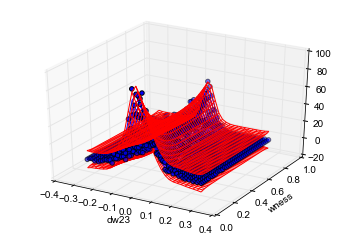

In [15]:
# create plots
''' # old plotting section:
m.plot()

figure, axes = plt.subplots(4,1)
for ax,y in zip(axes,[.2,.4,.6,.8]):
  m.plot(fixed_inputs=[(1,y)],ax=ax, which_data_rows=slice(0,30))
  plt.xlabel('wness prediction %i'%y)'''

# wireframe predicted distribution and error bands with data points
fig=plt.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(dw23range,wrange,mean,colors='blue')
ax.plot_wireframe(dw23range,wrange,upperBand,colors='red')
ax.plot_wireframe(dw23range,wrange,lowerBand,colors='red')
ax.scatter(scatterx,scattery,scatterz)
ax.set_xlabel('dw23')
ax.set_ylabel('wness')
plt.show()

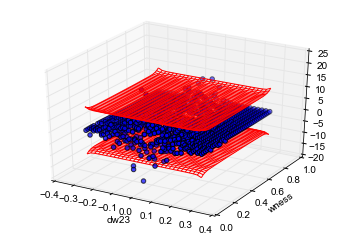

In [16]:
# difference in predicted distribution from data points with
# wireframe predicted uncertainty bands
fig=plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(dw23range,wrange,mean-scatterz)
ax.plot_wireframe(dw23range,wrange,var,colors='red')
ax.plot_wireframe(dw23range,wrange,-1*var,colors='red')
#ax.scatter(scatterx,scattery,scatterz)
ax.set_xlabel('dw23')
ax.set_ylabel('wness')
plt.show()

In [ ]:
'''# dw23 slices
def get_dw23_slice_prediction():
    return dw23slice'''

In [17]:
# used to prevent program from ending so plots
# don't close right away. Hit enter to end.
raw_input()

''